In [142]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.base import clone

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

### Training and Visualizing a Decision Tree

In [27]:
iris = datasets.load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [7]:
export_graphviz(tree_clf,
               out_file='iris_tree.dot',
               feature_names=iris.feature_names[2:],
               class_names=iris.target_names,
               rounded=True,
               filled=True)

In [9]:
!dot -Tpng iris_tree.dot -o iris_tree.png

In [12]:
Image(url= "iris_tree.png")

### Making Predictions

$$ G_{i} = 1 - \sum_{k = 1}^{n}p_{i,k}^{2}$$

In [15]:
1 - ((0 / 54) ** 2 + (49 / 54) ** 2 + (5 / 54) ** 2) # versicolor gini

0.16803840877914955

### Estimating Class Probabilites

In [16]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [17]:
tree_clf.predict([[5, 1.5]])

array([1])

### The CART Training Algorithm

$$ J(k, t_{k}) = \frac{m_{\mathrm{left}}}{m}G_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m}G_{\mathrm{right}} $$

$$ \mathrm{where} \left\{\begin{matrix}
G_{\mathrm{left/right}}\ \mathrm{measures\ the\ impurity\ of\ the\ left/right}
\\ m_{\mathrm{left/right}}\ \mathrm{is\ the\ number\ of\ instances\ in\ the\ left/right\ subset}
\end{matrix}\right.
$$
 
### Gini Impurity or Entropy?

$$ H_{i} = - \underset{p_{i, k} \neq 0}{\sum_{k = 1}^{n}}p_{i, k}\log_{2}(p_{i, k}) $$

In [23]:
-((49 / 54) * np.log2(49 / 54) + (5 / 54) * np.log2(5 / 54))

0.44506485705083865

### Regression

In [29]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

In [25]:
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [37]:
export_graphviz(tree_reg,
               out_file='quad_tree.dot',
               rounded=True,
               filled=True)

In [31]:
!dot -Tpng quad_tree.dot -o quad_tree.png

In [32]:
Image(url= "quad_tree.png")


$$ J(k, t_{k}) = \frac{m_{\mathrm{left}}}{m}\mathrm{MSE}_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m}\mathrm{MSE}_{\mathrm{right}} $$

$$
\mathrm{where}\; \left\{\begin{matrix}
\mathrm{MSE}_{\mathrm{node}} = \underset{i\ \in\ \mathrm{node}}{\sum}(\widehat{y}_{\mathrm{node}} - y^{(i)})^{2}
\\ \widehat{y}_{\mathrm{node}} = \frac{1}{m_{\mathrm{node}}}\underset{i\ \in\ \mathrm{node}}{\sum}y^{(i)}
\end{matrix}\right.
$$

### Exercises

#### 7.

In [90]:
X, y = datasets.make_moons(n_samples=10000, noise=0.4)

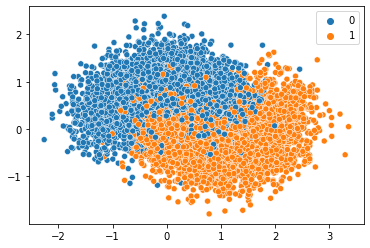

In [91]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.show()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [93]:
param_grid = {
    'max_leaf_nodes': [3, 5, 8],
    'max_depth': [1, 2, 3, 4],
    'min_samples_leaf': [10, 100, 1000]
}

tree_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(tree_clf, param_grid, cv=3, scoring='accuracy')

In [94]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4], 'max_leaf_nodes': [3, 5, 8],
                         'min_samples_leaf': [10, 100, 1000]},
             scoring='accuracy')

In [95]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=5, min_samples_leaf=10)

In [96]:
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.857

#### 8.

In [144]:
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [146]:
forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.785332

In [147]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [148]:
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [149]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.814